In [1]:
import matplotlib.pyplot as plt
import time
import numpy as np
from tqdm import tqdm
from kalmanfilter import KalmanFilter
import cv2
from Motion_control import MotionControl
import local_nav as ln
import math 
from computer_vision import Vision
from djikstra import djikstra_algo
from calibration import data

In [2]:
from tdmclient import ClientAsync, aw
client = ClientAsync()
node = aw(client.wait_for_node())
aw(node.lock())

Node 8686cf32-0aa4-410e-9c02-65fc7cdb6752

In [3]:
Ts = 0.1
SPEED_L = 101
SPEED_R = 99
GND_THRESHOLD = 400

mc = MotionControl(node, client, Ts, SPEED_R, SPEED_L)

In [4]:
#cal_data = data(Ts, SPEED_L, SPEED_R, GND_THRESHOLD, client, node, 0.329506587331065, 6.793596512574189)
cal_data = data(Ts, SPEED_L, SPEED_R, GND_THRESHOLD, client, node, 0.3186246426824248, 3.406791272962758)
cal_data.calibration_mm(mc)
mc.speed_conversion = cal_data.speed_conversion

The conversion factor for the speed of the thymio to mm/s is : 0.3186246426824248 
With a desired speed of : 100.0, the thymio speed is : 31.543839625560054 mm/s
The standard deviation from the speed state (q_nu) and speed measurement (r_nu) is : 3.406791272962758 
########################
YOU ARE IN A 'NO CALIBRATION' MODE. IF YOU WISH TO RUN CALIBRATION SEQUENCE, CHANGE THE CELL ABOVE WITH THIS CODE

cal_data = data(Ts, SPEED_L, SPEED_R, GND_THRESHOLD, client, node)
cal_data.calibration_mm(mc)
########################


In [13]:
DEBUG = False

nbAruco = 2
threshold = 100
calibrate = False
vision, Q_cam, R_cam = cal_data.cam_calibration(calibrate, nbAruco, threshold)

HALF_CELL_WIDTH = vision.cell_width/2
if(DEBUG == True):
    print("Number of obstacles = ", np.count_nonzero(vision.grid))
    print(vision.grid)
    lines = vision.show()
    plt.figure
    plt.title('Lines')
    plt.imshow(cv2.cvtColor(lines.astype('uint8'), cv2.COLOR_BGR2RGB))

ERROR MESSAGE: the goal was not detected
ERROR MESSAGE: the goal was not detected
ERROR MESSAGE: the goal was not detected
ERROR MESSAGE: the goal was not detected
ERROR MESSAGE: both the Thymio robot and the goal were not detected
ERROR MESSAGE: both the Thymio robot and the goal were not detected
ERROR MESSAGE: both the Thymio robot and the goal were not detected
ERROR MESSAGE: both the Thymio robot and the goal were not detected
ERROR MESSAGE: both the Thymio robot and the goal were not detected
ERROR MESSAGE: both the Thymio robot and the goal were not detected
ERROR MESSAGE: both the Thymio robot and the goal were not detected
ERROR MESSAGE: both the Thymio robot and the goal were not detected
ERROR MESSAGE: both the Thymio robot and the goal were not detected
ERROR MESSAGE: both the Thymio robot and the goal were not detected
ERROR MESSAGE: both the Thymio robot and the goal were not detected
ERROR MESSAGE: both the Thymio robot and the goal were not detected
ERROR MESSAGE: both 

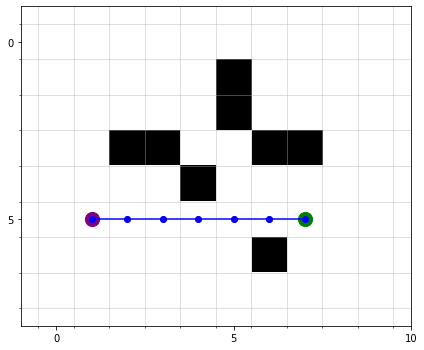

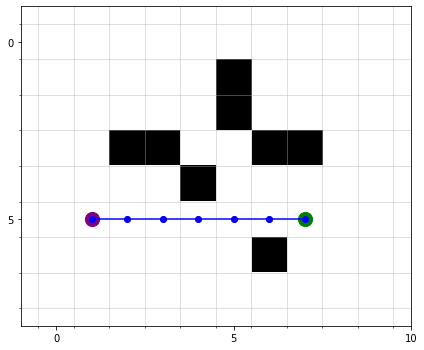

In [15]:
mc.step_duration = HALF_CELL_WIDTH*2 / (mc.SPEED_AVG * mc.speed_conversion)
mc.turn_duration = 98 / (mc.SPEED_AVG * mc.speed_conversion)
restart = True

jump_x, jump_y = 0,0
MARGIN = 30
change_dir = False
while (restart == True):
    jump = False
    index = 0
    restart = False
    vision.update_coordinates()
    if(DEBUG == True):
        print("thymio real pos : ", vision.thymio_real_pos)
        print("thymio pos in grid : ", vision.thymio_position)
        print("goal pos : ", vision.goal_position)
        print("thymio angle = :", vision.thymio_orientation)
    vision.grid[vision.thymio_position[1]][vision.thymio_position[0]] = 0
    vision.grid[vision.goal_position[1]][vision.goal_position[0]] = 0
    shortest_path = djikstra_algo(vision.grid.T, vision.thymio_position, vision.goal_position)
    if(DEBUG == True):
        print(shortest_path)
    KF = KalmanFilter(Ts, vision.thymio_real_pos, cal_data.speed_conversion, Q_cam, R_cam)
    mc.orientation = mc.correct_orientation(vision.thymio_orientation)
    x = vision.thymio_position[0]
    y = vision.thymio_position[1]
    speed = np.array([SPEED_L, SPEED_R])
    turn_speed = np.array([0, 0])
    for dx,dy in np.transpose(shortest_path):
        if jump:
            x = dx      #actualize the coordinates of the robot
            y = dy      #actualize the coordinates of the robot
            index += 1
            if jump_x == dx and jump_y == dy:
                jump = False
            continue  
        vision.update_coordinates()
        if(vision.goal_position != vision.goal_previous) & (change_dir != True):
            change_dir = True
            restart = True
            break
        turn = mc.get_turn(dx-x,dy-y,mc.orientation)
        mc.orientation = (mc.orientation + turn)%4
        for i in range(abs(turn)):
            mc.robot_turn(np.sign(turn))
        mc.adjust_angle(vision)
        if (((dx-x)!=0) | ((dy-y)!=0)):
            local = ln.obstacle_detect(node)
            if local:
                if(DEBUG == True):
                    print("obstacle",len(shortest_path[1]))
                jump,jump_x,jump_y = ln.obstacle_avoid(vision, mc, x, y, shortest_path, index, node, client)
            else:   
                if (((dx-x)!=0) | ((dy-y)!=0)):
                    step_done = False
                    start_move = time.time()
                    mc.motors(speed[0], speed[1])
                    temp = 0
                    next_target_x = dx *HALF_CELL_WIDTH*2 + HALF_CELL_WIDTH
                    next_target_y = (vision.rows - 1 - dy) *HALF_CELL_WIDTH*2 + HALF_CELL_WIDTH
                    
                    while (step_done != True):  
                        vision.update_coordinates()
                        kalman_pos= KF.filter(vision.thymio, vision.thymio_real_pos, speed, vision.thymio_orientation)
                        if(DEBUG == True):
                            print("estimated position ", kalman_pos)
                            print("position from camera ", vision.thymio_real_pos)
                        delta_x, delta_y= mc.kalman_adjust(next_target_x, next_target_y, kalman_pos, vision.thymio_orientation, vision.thymio)
                        current = time.time()
                        temp = current - start_move
                        if((np.abs(delta_x) < MARGIN) & (np.abs(delta_y) < MARGIN)):
                            step_done = True
                            mc.motors(0, 0) 
                        elif(temp > mc.step_duration):
                            step_done = True  
                            mc.motors(0, 0)
                
                    mc.adjust_angle(vision)

        x = dx      #actualize the coordinates of the robot
        y = dy      #actualize the coordinates of the robot
        index += 1

In [9]:
mc.motors(0,0)

In [18]:
print(cal_data.speed_conversion)

0.3186246426824248


In [19]:
print(mc.speed_conversion)

0.3186246426824248
